In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
import random, os, re

In [2]:
COLORBOX = ['#ca06b8', '#ca9236', '#5132c7', '#3bf48c', '#bed092']
COLORS_BY_STRAT = {'cautious':'#89a348', 'reckless':'#bd2f9e', 'corrupt':'#1e4054'}
MARKERS_BY_STRAT = {'cautious': 'X', 'reckless':'s', 'corrupt':'o'}

## Paper version of firstPlot

In [3]:
def firstPlot(filesource, strat_names, imsize = (12,5), plotname = 'reference_trace', loc='best'):    
    dfarray = []
    for strat_name in strat_names:
        df = pd.read_csv(f'{filesource}{strat_name}.csv')
        dfarray.append(df)
    state_labels = []
    states = []
    state_ticks = []
    for i in range(dfarray[0].shape[0]):
        states.append(i)
    for i in range(dfarray[0].shape[0]):
        if i < dfarray[0].shape[0] -1:
            state_labels.append(f"$s_{1*i + 1}$")
            state_ticks.append(1*i + 1)
    
    # set up the plots
    fig, axs1 = plt.subplots(figsize = imsize)
    axs1.set_xlim(0,dfarray[0].shape[0])
    for spine in ['right', 'top']:
        axs1.spines[spine].set_visible(False)
    markersize = 10

    # plotting data
    axs1.fill_between(states, dfarray[0]['Pmin'], dfarray[0]['Pmax'], color = '#DBDBDB')
    axs1.plot(states, dfarray[0]['Pmin'], color = '#1a4314', marker = 'v', markersize=markersize, label = "$\mathcal P_{\mathrm{min}}$", zorder=10, clip_on=False, alpha=0.6)
    axs1.plot(states, dfarray[0]['Pmax'], color = '#8d0000', marker = '^', markersize=markersize, label = "$\mathcal P_{\mathrm{max}}$", zorder=10, clip_on=False, alpha=0.6)

    # make a P line for each strategy chosen by user, new color, df will be new, new label
    for i in range(len(dfarray)):
        df = dfarray[i]
        strat_name = strat_names[i]
        colorused = COLORBOX[i%len(COLORBOX)] if strat_name not in COLORS_BY_STRAT else COLORS_BY_STRAT[strat_name]
        markerused = 'o' if strat_name not in MARKERS_BY_STRAT else MARKERS_BY_STRAT[strat_name]
        
        if strat_name == 'corrupt':
            label = "$\mathcal P_{\pi_1}$"
        if strat_name == 'reckless':
            label = "$\mathcal P_{\pi_2}$"
        if strat_name == 'cautious':
            label = "$\mathcal P_{\pi_3}$"
        
        axs1.plot(states, df['P'], color = colorused, marker = markerused, markersize=markersize,  label = label, zorder=10, clip_on=False, alpha=0.8)

    
    # labelling plot
    if loc != "None":
        axs1.legend(loc=loc)
    axs1.set_xlabel('States')
    plt.xticks(state_ticks, state_labels)
    axs1.set_ylabel('Probability')
    plt.yticks([0, 0.5, 1.0], ['0','0.5', '1.0'])
#     axs1.set_title('Raw probabilities')
    axs1.plot(1, 0, ">k", transform=axs1.get_yaxis_transform(), clip_on=False)
    
    # plt.tight_layout()
    axs1.margins(0)
#     plt.show()
    plt.savefig(f"../../ijcai23/{plotname}.pdf",bbox_inches='tight')

In [4]:
filesource = 'path_crash40/sliprange=30.55_slipfact=2.5_hesfact=0.6_visblock=False_data_'
strat_names3 = ['corrupt', 'reckless', 'cautious']
strat_names1 = ['corrupt']

In [5]:


# plot styling
# plt.rcParams.update({'axes.labelsize' : 18, 'axes.titlesize': 18, 'font.family': 'serif'})

plt.rcParams.update({'font.size': 34, 'axes.labelsize' : 34})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

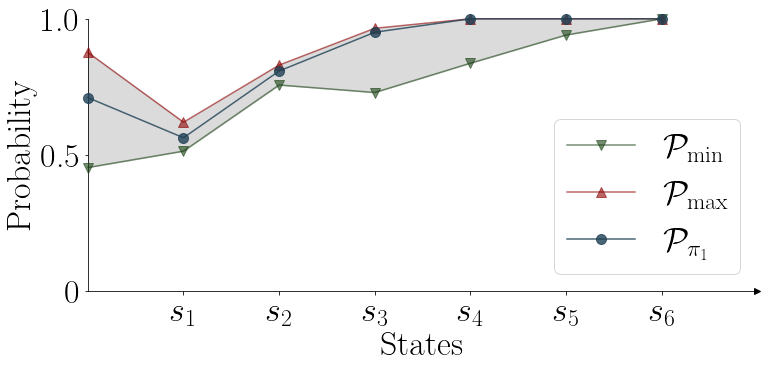

In [50]:
firstPlot(filesource, strat_names1, imsize=(12,5), plotname='reference_trace' )

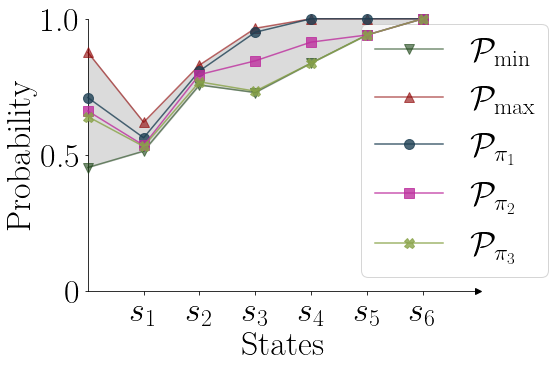

In [51]:
firstPlot(filesource, strat_names3, imsize=(7,5), plotname='reference_trace_3', loc=(0.7,0.05))

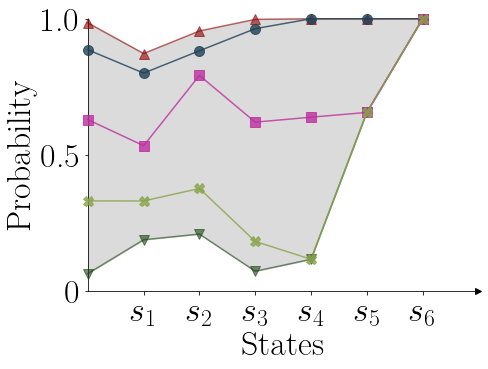

In [52]:
filesource_cf = 'path_crash40/sliprange=30.55_slipfact=1_hesfact=0.6_visblock=False_data_'
firstPlot(filesource_cf, strat_names3, imsize=(7,5), plotname='cf_trace_3', loc="None")

## Paper version of scatter plot

In [10]:
plt.rcParams.update({'font.size': 28, 'axes.labelsize' : 28})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

def parse_params_from_str(filename):
    parsed_params = {}
    slippery_range = re.compile('sliprange=[+-]?([0-9]*[.])?[0-9]+').search(filename).group().split('=')[-1].replace('.', ',')
    slippery_factor = re.compile('slipfact=[+-]?([0-9]*[.])?[0-9]+').search(filename).group().split('=')[-1]
    hesitant_factor = re.compile('hesfact=[+-]?([0-9]*[.])?[0-9]+').search(filename).group().split('=')[-1]
    use_visibility = re.compile('visblock=[a-zA-Z]*').search(filename).group().split('=')[-1]
    strategy = filename.split('_')[-1].split('.')[0]
    return slippery_range, slippery_factor, hesitant_factor, use_visibility, strategy

def counterfactualScatterPlot(folder_to_save, differentiate_visibility=False):
    counterfactual_df = pd.DataFrame(columns=['slippery_range', 'slippery_factor','hesitant_factor','use_visibility', 'strategy', 'agency','intention'],
                                index = range(len(os.listdir(folder_to_save))))
    curr_idx = 0
    for filename in os.listdir(folder_to_save):
        if filename.split('.')[-1] == 'csv':
            slippery_range, slippery_factor, hesitant_factor, use_visibility, strategy = parse_params_from_str(filename)
            df = pd.read_csv(f"{folder_to_save}/{filename}")
            df['agency'] = df.Pmax - df.Pmin
            df['intention'] = (df.P - df.Pmin)/df.agency
            df = df[df.agency > 0]
            df['agency_weights'] = df.agency/df.agency.sum()
            df['intention_weighted'] = df.intention*df.agency_weights

            intention = df.intention_weighted.sum()
            mean_agency = df.agency.mean()
            if 1.5*mean_agency > random.random():
                counterfactual_df.loc[curr_idx, :] = [slippery_range, slippery_factor, hesitant_factor, use_visibility,strategy,mean_agency,intention]
                curr_idx += 1
                
    counterfactual_df = counterfactual_df[counterfactual_df.index < curr_idx]
    
    counterfactual_df['color'] = "none"
    
    for i in counterfactual_df.index:
        try:
            counterfactual_df.loc[i,'color'] = COLORS_BY_STRAT[counterfactual_df.loc[i,'strategy']]
        except:
            pass
    
    counterfactual_df['agency_weights'] = counterfactual_df.agency/counterfactual_df.agency[counterfactual_df.strategy=='cautious'].sum()
    counterfactual_df['intention_weighted'] = counterfactual_df.agency_weights*counterfactual_df.intention
    visibilities = [{"True"}, {"False"}, {"True", "False"}] if differentiate_visibility else [{"True", "False"}]
    
    for visibility in visibilities:
        fig, axs1 = plt.subplots(figsize = (8, 5))

#         for strat_name in counterfactual_df.strategy.unique():
        for strat_name in strat_names3:
            slice_df = counterfactual_df[counterfactual_df.strategy == strat_name]
            slice_df = slice_df[slice_df.use_visibility.isin(visibility)]
            weighted_intention = slice_df.intention_weighted.sum()
            if strat_name == 'corrupt':
                label = "$\pi_1$"
            if strat_name == 'reckless':
                label = "$\pi_2$"
            if strat_name == 'cautious':
                label = "$\pi_3$"
            markersize=120
            markerused = 'o' if strat_name not in MARKERS_BY_STRAT else MARKERS_BY_STRAT[strat_name]
            axs1.scatter(x=slice_df.agency, y=slice_df.intention, 
                      c = slice_df.color.unique()[0], 
                s=markersize, marker = markerused, label = label)

        axs1.set_xlim(0,1)
        axs1.set_ylim(0,1)
        plt.xticks([0,0.5,1], [0, 0.5, 1])
        plt.yticks([0.5,1], [0.5, 1])

        axs1.legend(loc=(1,0.5))
        axs1.set_xlabel('Scope-of-agency')
        axs1.set_ylabel('Intention-quotient')
        plotname = "scatterplot"

        plt.savefig(f"{plotname}.pdf",bbox_inches='tight')
        print(curr_idx)


321


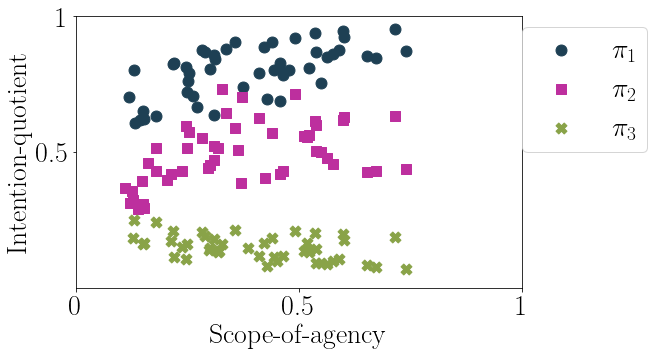

In [12]:
folder_to_save = 'path_crash40_sample'
counterfactualScatterPlot(folder_to_save)